## Chapter 31 Project: Annual Water Usage in Baltimore

### Overview
- Problem Description
- Test Harness
- Persistance
- Data Analysis
- ARIMA Models
- Model Validation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#### 1. Problem Description

The problem is to predict annual water usage. The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per capita per day, and there are 79 observations. The dataset is credited to Hipel and McLeod, 1994.

In [2]:
series = pd.read_csv('data/water.csv', index_col=0, parse_dates=True)
print(series.shape)
series.head()

(79, 1)


,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


In [3]:
series.tail()

,Water
Year,
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625
1963-01-01,613


#### 2. Test Harness

We must develop a test harness to investigate the data and evaluate candidate models. This involves two steps:
- Defining a Validation Dataset.
- Developing a Method for Model Evaluation.

##### (1) Validation Dataset

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore, we will pretend that it is 1953 and withhold the last 10 years of data from analysis and model selection. This final decade of data will be used to validate the final model.

In [4]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[:split_point], series[split_point:]
print(f'Dataset {len(dataset)}, Validation {len(validation)}')
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 69, Validation 10


##### (2) Model Evaluation

The RMSE performance measure and walk-forward validation will be used for model evaluation.

#### 3. Persistence

In [5]:
# evaluate a persistence model
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Water'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

#### 4. Data Analysis

We will look at the data from four perspectives:
- Summary Statistics
- Line Plot
- Density Plot
- Box and Whisker Plot

##### (1) Summary Statistics

In [6]:
# summary statistics of time series
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
series.describe()

,Water
count,69.000000
mean,500.478261
std,73.901685
min,344.000000
25%,458.000000
50%,492.000000
75%,538.000000
max,662.000000


Some observations from these statistics include:
- THe mean is about 500, which we might consider our level in this series.
- The standard deviation and perecentiles suggest a reasonable tight spread around the mean.

##### (2) Line Plot

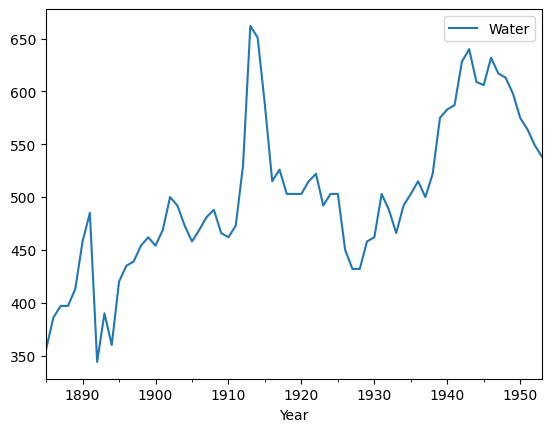

In [7]:
# line plot of time series
series.plot()
plt.show()

Some observations from the plot include:
- There looks to be an increasing trend in water usage over time.
- There do not appear to be any obvious outliers, although there some some large fluctuations.
- There is a downward trend for the last few years of the series.

There may be some benefit in explicitly modeling the trend component and removing it. You may also explore using diﬀerencing with one or two levels in order to make the series stationary.

##### (3) Density Plots

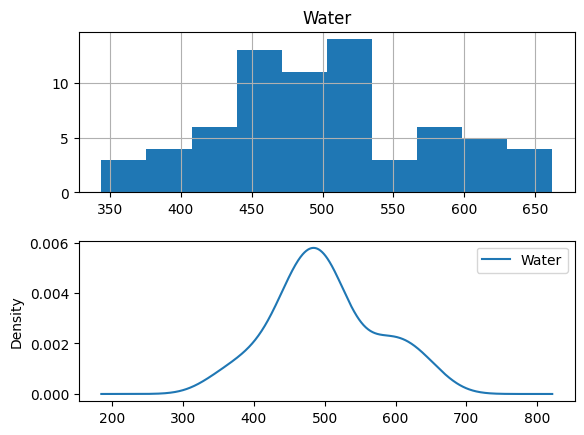

In [8]:
# density plots of time series
plt.figure()
plt.subplot(211)
series.hist(ax=plt.gca())
plt.subplot(212)
series.plot(kind='kde', ax=plt.gca())
plt.show()

Some observations from the plots include:
- The distribution is not Gaussian, but is pretty close.
- The distribution has a long right tail and may *suggest an exponential distribution or a double Gaussian*.

This suggests it may be worth exploring some *power transforms* of the data prior to modeling.

##### (4) Box and Whisker Plot

We can group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing. We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing. The last decade only contains 9 years and may not be a useful
comparison with the other decades. Therefore only data between 1885 and 1944 was plotted.

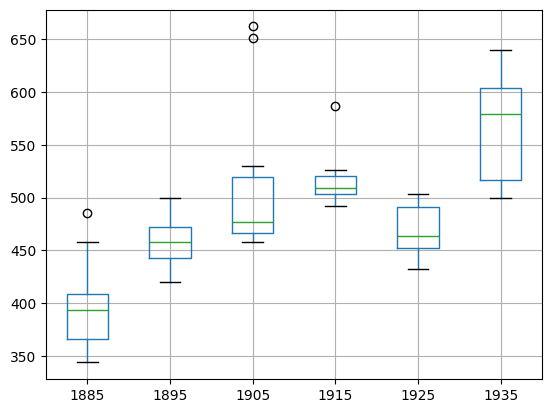

In [9]:
# boxplots of time series
df = pd.read_csv('dataset.csv', parse_dates=True)
df['year'] = pd.to_datetime(df['Year']).dt.year
df = df[df['year'] < 1945 ].reset_index(drop=True)
decades = list()
for i in range(len(df)):
  year = df['year'].astype(int).values[i]
  if (year >= 1885) & (year < 1895):
    decades.append(1885)
  elif year < 1905:
    decades.append(1895)
  elif year < 1915:
    decades.append(1905)
  elif year < 1925:
    decades.append(1915)
  elif year < 1935:
    decades.append(1925)
  elif year < 1945:
    decades.append(1935)
  else:
    assert False, "Years out of range"

df['decade'] = np.array(decades)
groups = df.groupby('decade')
decades = pd.DataFrame()
for name, group in groups:
  decades[name] = group['Water'].astype(float).values
decades.boxplot()
plt.show()

Some observations from reviewing the plot include:
- The median values for each year may show an increasing trend that may not be linear.
- The spread, or middle 50% of the data, does show some variability.
- There maybe outliers in soem decades (crosses outside of the box and whiskers).
- The second to last decade seems to have a lower average consumption, perhaps related to the first world war.

This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from decade-to-decade and changes in summary statistics.

#### 5. ARIMA Models

##### (1) Manually Configure the ARIMA

The `ARIMA(p,d,q)` model requires three parameters and is traditionally configured manually.
Analysis of the time series data assumes that we are working with a stationary time series. The time series is likely non-stationary. We can make it stationary by first diﬀerencing the series and using a statistical test to confirm that the result is stationary.

ADF Statistic: -6.126718808474715
p-value: 8.593851954694127e-08
Critical Values:
	 1%, -3.534
	 5%, -2.906
	 10%, -2.591


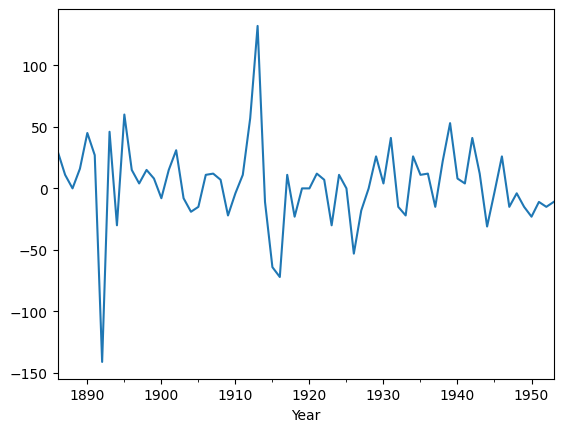

In [10]:
# create and summarize a stationary version of the time series
# create a differenced series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = series['Water'].astype(float).values

# difference data
stationary = difference(X)
stationary.index = series.index[1:]

# check if stationary
result = adfuller(stationary)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
  print(f'\t {key}, {value:.3f}')

# plot differenced data
stationary.plot()
plt.show()

# save
stationary.to_csv('stationary.csv')

The results show that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have
time-dependent structure.

This suggests that at least one level of diﬀerencing is required. The d parameter in our ARIMA model should at least be a value of 1. A plot of the diﬀerenced data is also created. It suggests that this has indeed removed the increasing trend.

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function
(ACF) and Partial Autocorrelation Function (PACF) plots.

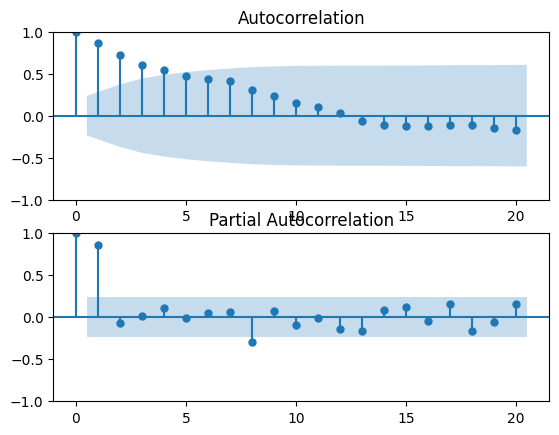

In [11]:
# ACF and PACF plots of the time series
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
plt.figure()
plt.subplot(211)
plot_acf(series, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=20, ax=plt.gca())
plt.show()

Some observations from the plots:
- The ACF shows significant lags to 4 time steps.
- The PACF shows significant lags to 1 time step.

A good starting point for the p is 4 and q is 1.

This quick analysis suggests an ARIMA(4,1,1) on the raw data may be a good starting point.

In [12]:
# evaluate a manually configured ARIMA model
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Water'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(4,1,1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Predicted=530.101, Expected=503.000
>Predicted=511.154, Expected=503.000
>Predicted=515.637, Expected=515.000
>Predicted=520.904, Expected=522.000
>Predicted=525.009, Expected=492.000
>Predicted=492.360, Expected=503.000
>Predicted=504.664, Expected=503.000
>Predicted=512.082, Expected=450.000
>Predicted=454.312, Expected=432.000
>Predicted=441.329, Expected=432.000
>Predicted=452.418, Expected=458.000
>Predicted=470.223, Expected=462.000
>Predicted=465.860, Expected=503.000
>Predicted=498.112, Expected=488.000
>Predicted=483.399, Expected=466.000
>Predicted=455.128, Expected=492.000
>Predicted=492.320, Expected=503.000
>Predicted=503.711, Expected=515.000
>Predicted=505.815, Expected=500.000
>Predicted=493.165, Expected=522.000
>Predicted=515.482, Expected=575.000
>Predicted=571.332, Expected=583.000
>Predicted=568.102, Expected=587.000
>Predicted=567.410, Expected=628.000
>Predicted=620.638, Expected=640.000
>Predicted=632.546, Expected=609.000
>Predicted=594.338, Expected=606.000
>

Running this example results in an RMSE of 25.262, which is higher than the persistence model above.

##### (2) Automatically Configure the ARIMA

The ACF and PACF plots suggest that we cannot do better than a persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and
check that no models result in better out-of-sample RMSE performance.

We will also disable the automatic addition of a trend constant from the model by setting the trend argument to `nc` for no constant when calling fit().

In [13]:
# grid search ARIMA parameters for a time series
import warnings
warnings.filterwarnings('ignore')

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype(float)
  train_size = int(len(X) * 0.50)
  train, test = X[:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for i in range(len(test)):
    model = ARIMA(history, order=arima_order, trend='n') # disable addition of a trend constant term
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[i])
  # calculate out of sample error
  rmse = np.sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combination of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype(float)
  best_score, best_cfg = float('inf'), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, d, q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print(f'ARIMA {order} RMSE={rmse:.3f}')
        except:
          continue
  print(f'Best ARIMA {best_cfg} RMSE={best_score:.3f}')

# load dataset
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series['Water'].values, p_values, d_values, q_values)

ARIMA (0, 0, 0) RMSE=536.978
ARIMA (0, 0, 1) RMSE=282.805
ARIMA (0, 0, 2) RMSE=183.320
ARIMA (0, 1, 0) RMSE=21.975
ARIMA (0, 1, 1) RMSE=21.907
ARIMA (0, 1, 2) RMSE=22.178
ARIMA (0, 2, 0) RMSE=28.992
ARIMA (0, 2, 1) RMSE=22.314
ARIMA (0, 2, 2) RMSE=22.196
ARIMA (1, 0, 0) RMSE=22.154
ARIMA (1, 0, 1) RMSE=22.086
ARIMA (1, 0, 2) RMSE=22.256
ARIMA (1, 1, 0) RMSE=21.921
ARIMA (1, 1, 1) RMSE=21.879
ARIMA (1, 1, 2) RMSE=23.314
ARIMA (1, 2, 0) RMSE=27.464
ARIMA (1, 2, 1) RMSE=22.219
ARIMA (1, 2, 2) RMSE=22.782
ARIMA (2, 0, 0) RMSE=22.100
ARIMA (2, 0, 1) RMSE=22.711
ARIMA (2, 0, 2) RMSE=22.523
ARIMA (2, 1, 0) RMSE=21.732
ARIMA (2, 1, 1) RMSE=23.823
ARIMA (2, 1, 2) RMSE=27.510
ARIMA (2, 2, 0) RMSE=25.282
ARIMA (2, 2, 1) RMSE=22.064
ARIMA (2, 2, 2) RMSE=23.255
Best ARIMA (2, 1, 0) RMSE=21.732


The results show that the best configuration discovered was ARIMA(2,1,0) with an RMSE of 21.732, slightly lower than the persistence model tested earlier, but may or may not be significant different.

##### (3) Review Residual Errors

A good final check of a model is to review residual forecast errors. *Ideally, the distribution of residual errors should be a Gaussian with a zero mean*. We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(2,1,0) model.

RMSE: 21.732
               0
count  35.000000
mean    1.081458
std    22.022201
min   -52.104849
25%   -16.209637
50%    -0.454858
75%    12.089062
max    51.281127


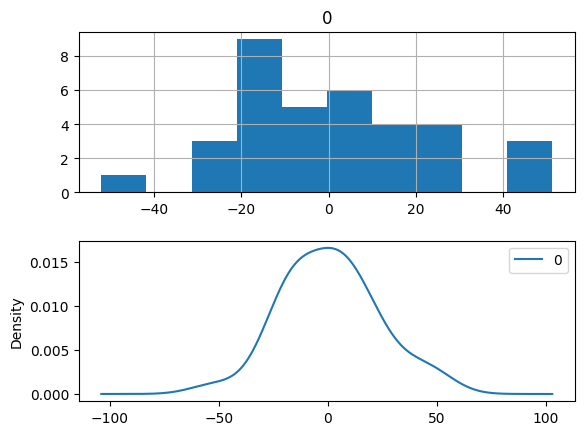

In [17]:
# summarize residual errors for an ARIMA model
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Water'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2,1,0), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')
# summarize residual errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a longer right tail, providing further evidence that perhaps a power transform
might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error of 1.081458 to each forecast made.

RMSE: 21.705
                  0
count  3.500000e+01
mean  -2.602947e-07
std    2.202220e+01
min   -5.318631e+01
25%   -1.729110e+01
50%   -1.536316e+00
75%    1.100760e+01
max    5.019967e+01


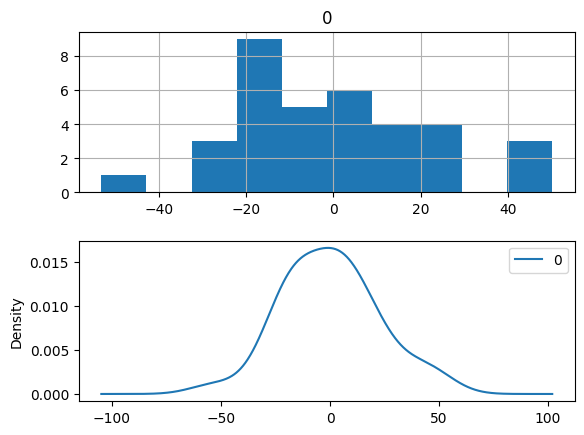

In [18]:
# summarize residual errors from bias corrected forecasts
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Water'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081458
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2,1,0), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast()[0] + bias
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')
# summarize residual errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The performance of the predictions is improved very slightly from 21.732 to 21.705, which may or may not be significant. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. Finally, density plots of the residual error do show a small shift towards zero.

#### 6. Model Validation

#### (1) Finalize Model: Train and save the final model

Finalizing the model involves fitting an ARIMA model on the entire dataset. Once fit, the model can be saved to file for later
use.

In [19]:
# save finalized model to file
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Water'].astype(float).values
# fit model
model = ARIMA(X, order=(2,1,0), trend='n')
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 1.081458
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', bias)

##### (2) Make Prediction: Load the finalized model and make a prediction

In [20]:
# load finalized model and make a prediction
model_fit_loaded = model_fit.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = model_fit_loaded.forecast()[0] + bias
print(f'Predicted: {yhat:.3f}')

Predicted: 540.011


If we peek inside validation.csv, we can see that the value on the first row for the next time period is 568. The prediction is in the right ballpark.

##### (3) Validate Model: Load and validate the final model

As with model evaluation in the previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

>Predicted=540.011, Expected=568.000
>Predicted=571.593, Expected=575.000
>Predicted=573.292, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.064, Expected=602.000
>Predicted=603.025, Expected=594.000
>Predicted=593.177, Expected=587.000
>Predicted=588.556, Expected=587.000
>Predicted=588.796, Expected=625.000
>Predicted=627.947, Expected=613.000
RMSE: 16.533


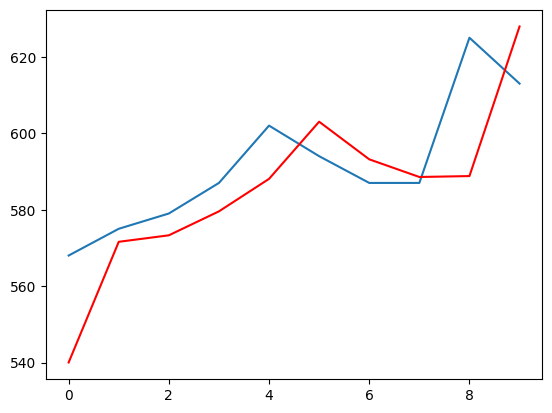

In [31]:
# load and evaluate the finalized model on the validation dataset
# load and prepare datasets
dataset = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = dataset['Water'].astype(float).values
history = [x for x in X]
validation = pd.read_csv('validation.csv', index_col=0, parse_dates=True)
y = validation['Water'].astype(float).values
# load model
model_fit_loaded = model_fit.load('model.pkl')
bias_loaded = np.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = model_fit_loaded.forecast()[0] + bias_loaded
predictions.append(yhat)
history.append(y[0])
print(f'>Predicted={yhat:.3f}, Expected={y[0]:.3f}')
# rolling forecasts
for i in range(1, len(y)):
  # predict
  model = ARIMA(history, order=(2,1,0), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast()[0] + bias_loaded
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse:.3f}')
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()